**Table of contents**<a id='toc0_'></a>    
- 1. [Measuring synchronization of activity in Nankai  ](#toc1_)    
- 2. [Load data ](#toc2_)    
- 3. [Compute correlation distance ](#toc3_)    
- 4. [Figures for paper](#toc4_)    
  - 4.1. [Supplementary figure](#toc4_1_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>Measuring synchronization of activity in Nankai   [&#128285;](#toc0_)

In [1]:
# Imports
%matplotlib widget
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import os
import sys
# if my user name is gafarge then use the following path
if os.getlogin() == 'gafarge':
    sys.path.append('/home/gafarge/py_modules/my_modules')
    workdir = '/home/gafarge/'
elif os.getlogin() == 'root':
    sys.path.append('/Users/gaspard/Documents/work/py_modules/my_modules')
    workdir = '/Users/gaspard/Documents/work/'
from stats import cross_corr

In [2]:
mag_min = 2.2

# 2. <a id='toc2_'></a>Load data  [&#128285;](#toc0_)

In [6]:
# Tremor data
trm = pd.read_csv('data/nankai/processed/nank_trm_clust_0404_0413_trim_eqdist_mc{:.1f}.csv'.format(mag_min), parse_dates=['date'])

In [7]:
# Earthquake data
eq = pd.read_csv('data/nankai/processed/nank_eqmc{:.1f}_0404_0413_trim_eqdist.csv'.format(mag_min), parse_dates=['date'])

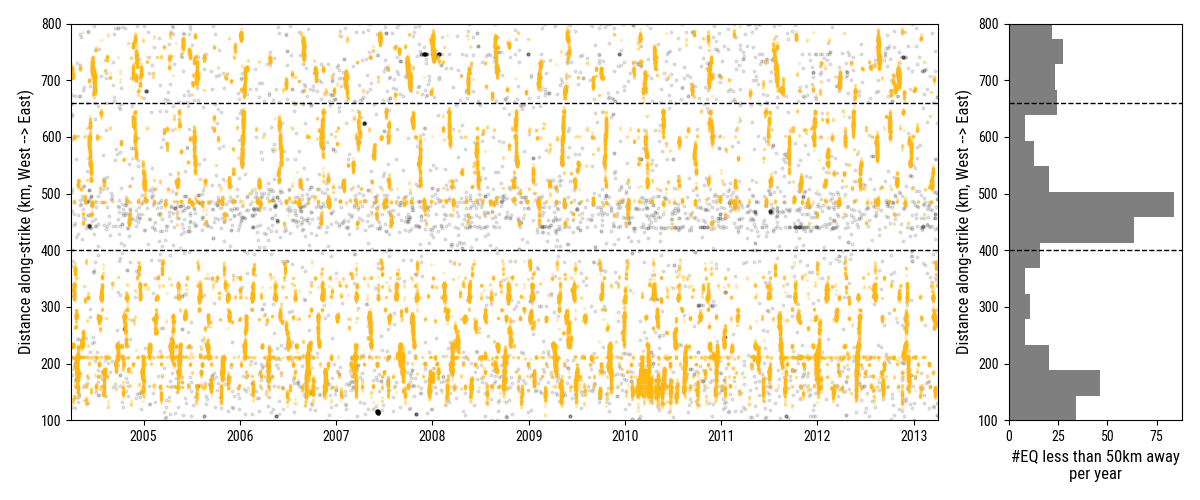

In [8]:
# Overview
fig = plt.figure(figsize=(12, 5))
gs = fig.add_gridspec(1, 2, width_ratios=[1, .2])

# # Map
# # crs = ccrs.TransverseMercator(central_longitude=trm.lon.mean(), central_latitude=trm.lat.mean())
# crs = ccrs.PlateCarree()
# ax = fig.add_subplot(gs[0, 0], projection=crs)
# min_lat = 32.5
# max_lat = 35.7
# min_lon = 131
# max_lon = 138.5
# ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
# ax.coastlines(lw=1)
# ax.add_feature(cfeature.LAND, color='lightgrey')

# ax.plot(trm.lon, trm.lat, 'o', ms=1, color='C2', transform=ccrs.PlateCarree())
# ax.plot(eq.lon, eq.lat, 'o', ms=1, color=to_rgba('k', .1), transform=ccrs.PlateCarree(), zorder=0)

# # grid and labels, only bottom and left, not top and right
# ax.set_xticks(np.arange(min_lon, max_lon+1, 2), crs=crs)
# ax.set_yticks(np.arange(np.ceil(min_lat), max_lat, 1), crs=crs)
# ax.xaxis.set_major_formatter(LongitudeFormatter())
# ax.yaxis.set_major_formatter(LatitudeFormatter())
# ax.grid('on', linestyle='--', alpha=0.5)

# Time-strike activity
ax = fig.add_subplot(gs[0, 0])
ax.set_ylabel('Distance along-strike (km, West --> East)')
ax.set_ylim(100, 800)
ax.set_xlim(trm.date.min(), trm.date.max())

ax.plot(trm.date, trm.xf, 'o', ms=1.5, color=to_rgba('C2', .2), label='Tremor')
ax.plot(eq.date[eq.in50km], eq.xf[eq.in50km], 'o', ms=2, color=to_rgba('k', .1), label='Earthquake', zorder=0)

# Histogram
ax = fig.add_subplot(gs[0, 1])
ax.set_xlabel('#EQ less than 50km away\nper year')
ax.set_ylabel('Distance along-strike (km, West --> East)')
ax.set_ylim(100, 800)

years = (eq.date.max() - eq.date.min()).days / 365
ax.hist(eq.xf[eq.in50km], weights=np.ones(len(eq.xf[eq.in50km]))/years, bins=20, color='k', alpha=.5, orientation='horizontal', histtype='stepfilled', lw=0)

for ax in fig.axes:
    ax.axhline(400, color='k', lw=1, ls='--')
    ax.axhline(660, color='k', lw=1, ls='--')

plt.tight_layout()
plt.show()

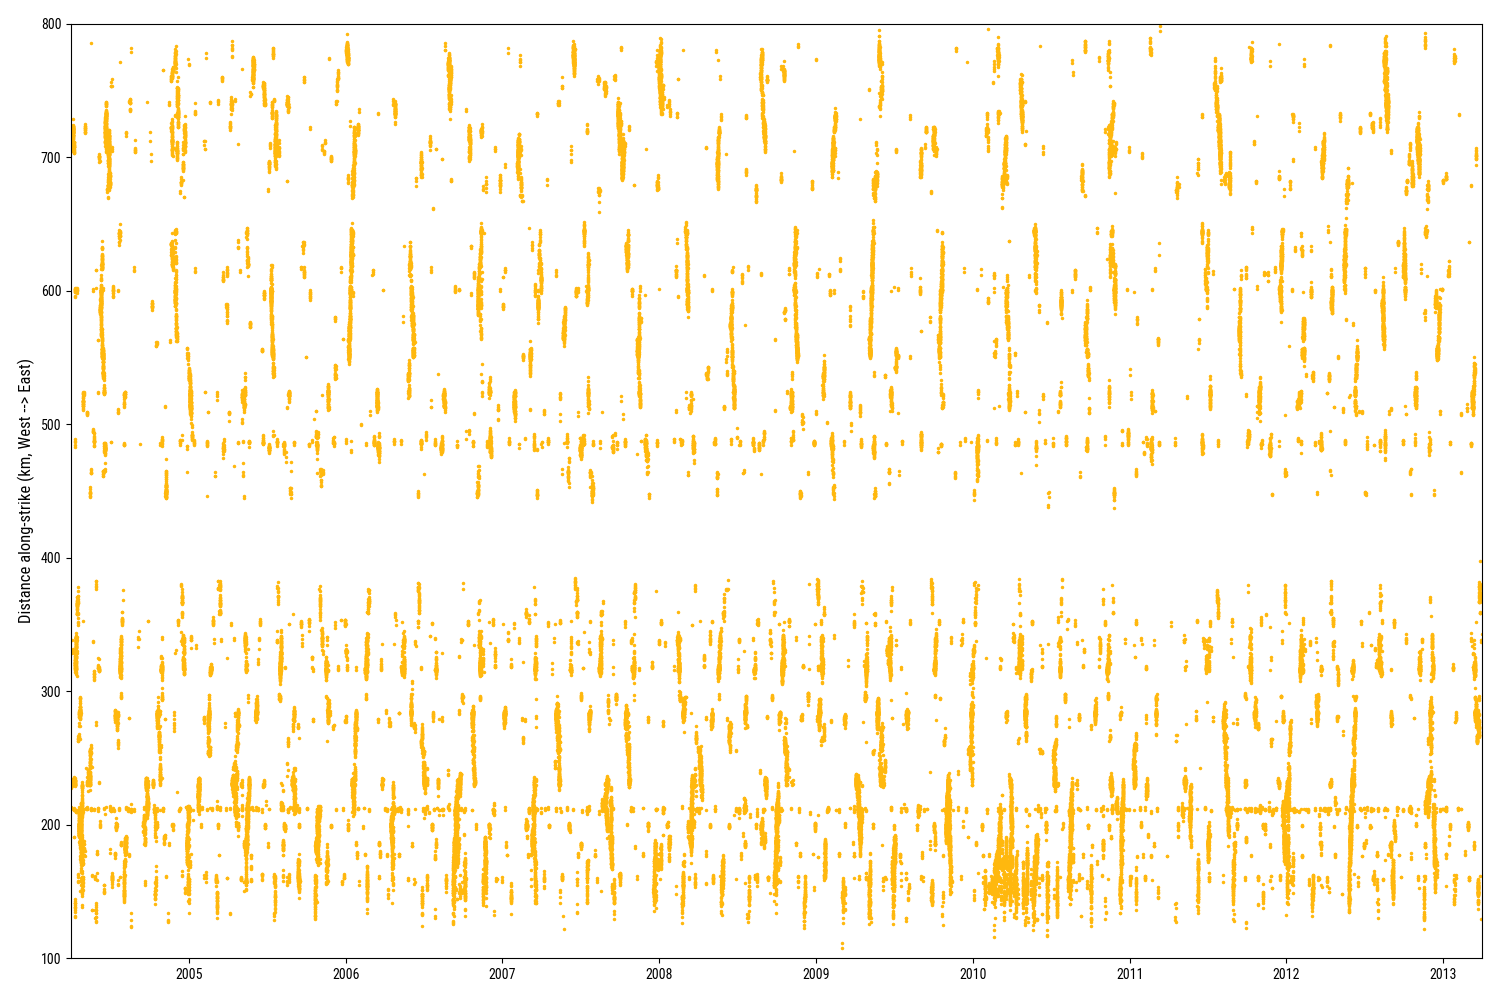

In [9]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_ylabel('Distance along-strike (km, West --> East)')
ax.set_ylim(100, 800)
ax.set_xlim(trm.date.min(), trm.date.max())
ax.plot(trm.date, trm.xf, 'o', ms=1.5, color=to_rgba('C2', 1), label='Tremor')
plt.tight_layout()
plt.show()

# 3. <a id='toc3_'></a>Compute correlation distance  [&#128285;](#toc0_)

In [10]:
# Make the matrix of cross-correlation — Parameters
# --> Define the spatial bins
dx_bin = 10  # in km, width of bin
xmin_bin = 100
xmax_bin = 800
x_bin_edges = np.arange(xmin_bin, xmax_bin + dx_bin, dx_bin)

# --> Parameters for the temporal counts
delta = 1  # in days, width of the temporal bin to count tremor events

# --> Parameters for the correlation
norm = True
no_bias = True
look_both_ways = True  # to add the negative lags to the positive

# --> Minimum speed of communication to consider (affects where we look for maximum lag)
v_min = 3.5  # in km/day

In [11]:
# Make the matrix of cross-correlation — Computation (takes time, 30s for bins of 10 km, 1 day, 1000 km wide)
# --> Make the counts
count_time = np.arange(0, trm.day.max()+delta, delta)
counts = np.zeros((len(x_bin_edges)-1, len(count_time)-1))

for ii in range(len(x_bin_edges)-1):
    x_min = x_bin_edges[ii]
    x_max = x_bin_edges[ii+1]
    trm_in_bin = trm.xf.between(x_min, x_max)
    counts[ii, :] = np.histogram(trm[trm_in_bin].day.values, bins=count_time)[0]

# --> Compute the cross-correlation matrix
cc_matrix = np.zeros((len(x_bin_edges)-1, len(x_bin_edges)-1))
lag_matrix = np.zeros((len(x_bin_edges)-1, len(x_bin_edges)-1))

for ii in range(len(x_bin_edges)-1):
    print('{}/{}'.format(ii+1, len(x_bin_edges)-1))
    for jj in range(len(x_bin_edges)-1):
        if jj <= ii:
            if ~np.any(counts[ii, :]) or ~np.any(counts[jj, :]):
                cc_matrix[ii, jj] = cc_matrix[jj, ii] = np.nan
                lag_matrix[ii, jj] = lag_matrix[jj, ii] = np.nan
            else:
                cc, lag = cross_corr(counts[ii, :], counts[jj, :], delta, norm=norm, no_bias=no_bias)
                
                if look_both_ways:
                    cc = (cc + cc[::-1]) / 2
                    cc = cc[lag >= 0]
                    lag = lag[lag >= 0]
                
                in_window = np.abs(lag) <= abs((x_bin_edges[ii+1] + x_bin_edges[ii])/2 - (x_bin_edges[jj+1] + x_bin_edges[jj])/2) / v_min
                cc_matrix[ii, jj] = cc_matrix[jj, ii] = np.max(cc[in_window])
                lag_matrix[ii, jj] = lag_matrix[jj, ii] = lag[in_window][np.argmax(cc[in_window])]

1/70
2/70
3/70
4/70
5/70
6/70
7/70
8/70
9/70
10/70
11/70
12/70
13/70
14/70
15/70
16/70
17/70
18/70
19/70
20/70
21/70
22/70
23/70
24/70
25/70
26/70
27/70
28/70
29/70
30/70
31/70
32/70
33/70
34/70
35/70
36/70
37/70
38/70
39/70
40/70
41/70
42/70
43/70
44/70
45/70
46/70
47/70
48/70
49/70
50/70
51/70
52/70
53/70
54/70
55/70
56/70
57/70
58/70
59/70
60/70
61/70
62/70
63/70
64/70
65/70
66/70
67/70
68/70
69/70
70/70


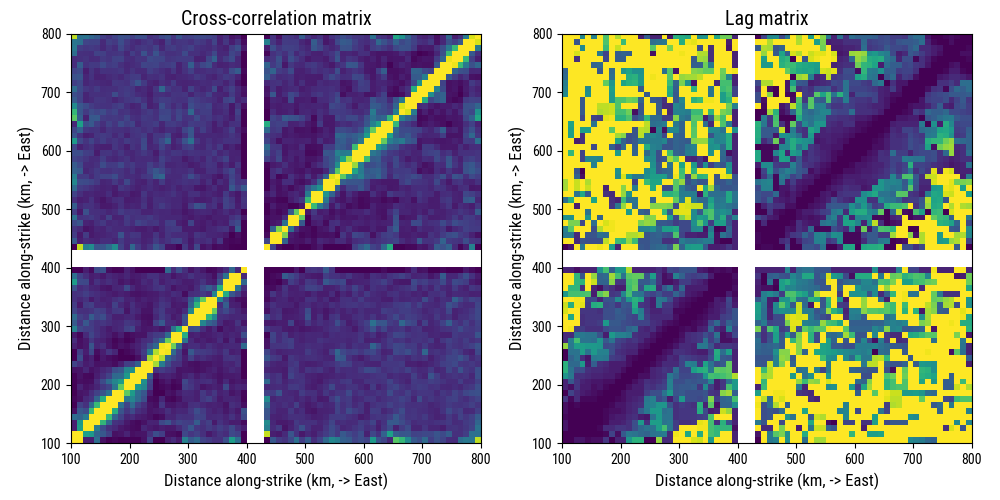

In [12]:
# Show the matrices
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax = axes[0]

# from matplotlib.colors import LinearSegmentedColormap
# nlow = int(256 * 0.1 // 1)
# nhigh = int(256 - nlow)
# cm_low = plt.cm.Greys_r(np.linspace(0, 1, nlow))
# cm_high = plt.cm.YlOrBr_r(np.linspace(0, 1, nhigh))
# colors = np.vstack((cm_low, cm_high))
# mymap = LinearSegmentedColormap.from_list('my_colormap', colors)

cax = ax.imshow(cc_matrix, extent=[xmin_bin, xmax_bin, xmin_bin, xmax_bin], origin='lower', cmap='viridis', vmin=0, vmax=.4)
ax.set_xlabel('Distance along-strike (km, -> East)')
ax.set_ylabel('Distance along-strike (km, -> East)')
ax.set_title('Cross-correlation matrix')

ax = axes[1]
cax = ax.imshow(lag_matrix, extent=[xmin_bin, xmax_bin, xmin_bin, xmax_bin], vmin=0, vmax=50, origin='lower')
ax.set_xlabel('Distance along-strike (km, -> East)')
ax.set_ylabel('Distance along-strike (km, -> East)')
ax.set_title('Lag matrix')

plt.tight_layout()
plt.show()

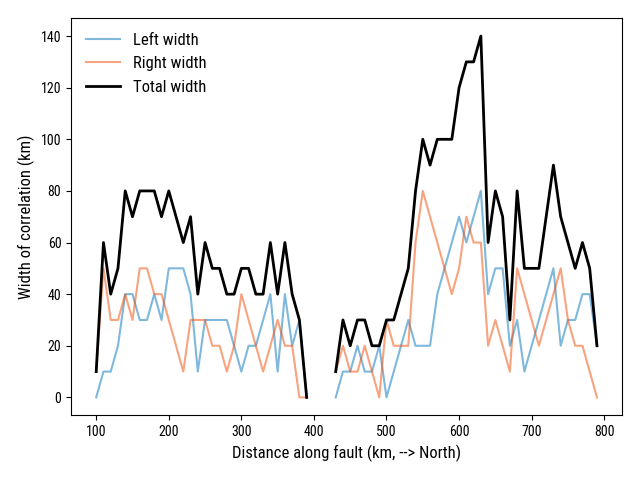

In [13]:
# Look how far you are above a threshold
threshold_cc = .07
left_width = []
right_width = []

for ii in range(len(x_bin_edges)-1):
    # Look right
    jj = ii
    while (jj < len(x_bin_edges)-1) and (cc_matrix[ii, jj] > threshold_cc):
        jj += 1
    right_width.append(x_bin_edges[jj-1] - x_bin_edges[ii])

    # Look left
    jj = ii
    while (jj >= 0) and (cc_matrix[ii, jj] > threshold_cc):
        jj -= 1
    left_width.append(x_bin_edges[ii] - x_bin_edges[jj+1])

left_width = np.array(left_width).astype(float)
right_width = np.array(right_width).astype(float)

# Remove wrong points
left_width[~np.any(counts, axis=1)] = np.nan
right_width[~np.any(counts, axis=1)] = np.nan

corr_length = np.array(left_width) + np.array(right_width)

# Show results
fig, ax = plt.subplots()
ax.set_xlabel('Distance along fault (km, --> North)')
ax.set_ylabel('Width of correlation (km)')
ax.plot(x_bin_edges[:-1], left_width, '-', label='Left width', alpha=0.5)
ax.plot(x_bin_edges[:-1], right_width, '-', label='Right width', alpha=0.5)
ax.plot(x_bin_edges[:-1], corr_length, 'k-', label='Total width', lw=2)
ax.legend()
plt.tight_layout()
plt.show()

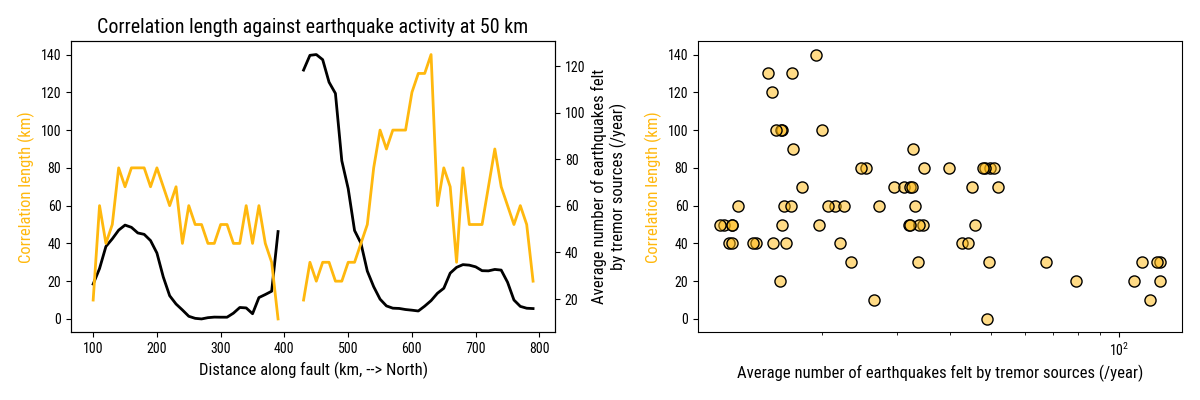

In [14]:
# Against earthquake activity
# --> Compute binned measure of earthquake activity
dists = [10, 20, 30, 50, 100]  # different distances in km

n_close_eq = {}
for dist in dists:
    n_close_eq[dist] = np.zeros(len(x_bin_edges)-1)
    for ii in range(len(x_bin_edges)-1):
        x_min = x_bin_edges[ii]
        x_max = x_bin_edges[ii+1]
        trm_in_bin = trm[trm.xf.between(x_min, x_max)]
        n_close_eq[dist][ii] = np.mean(trm_in_bin[f'n_eq_{dist}km'])

# Plot
chosen_dist = 50
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# --> In space
ax = axes[0]
ax.set_title(f'Correlation length against earthquake activity at {chosen_dist} km')
ax.set_xlabel('Distance along fault (km, --> North)')
ax.set_ylabel('Correlation length (km)', color='C2')
ax.plot(x_bin_edges[:-1], corr_length, 'C2-', lw=2)

ax_eq = ax.twinx()
ax_eq.set_zorder(-10)
ax.set_facecolor('none')
ax_eq.set_ylabel('Average number of earthquakes felt\nby tremor sources (/year)', color='k')
ax_eq.plot(x_bin_edges[:-1], n_close_eq[chosen_dist], 'k-', lw=2)

# --> One against the other
ax = axes[1]
ax.set_xlabel('Average number of earthquakes felt by tremor sources (/year)')
ax.set_ylabel('Correlation length (km)', color='C2')
ax.plot(n_close_eq[chosen_dist], corr_length, 'o', ms=8, mec='k', mfc=to_rgba('C2', .5))
ax.set_xscale('log')

plt.tight_layout()
plt.show()

In [15]:
# Stats
from scipy.stats import linregress

# Remove nans for the regression
n_eq = n_close_eq[chosen_dist][~np.isnan(corr_length)]
corr_l = corr_length[~np.isnan(corr_length)]

slope, intercept, r_value, p_value, std_err = linregress(n_eq, corr_l)
print('Slope:{:.2f}'.format(slope))
print('Error on slope (std): ±{:.2f}'.format(std_err))
print('Corellation coefficient:{:.2f}'.format(r_value))

SSres = np.sum((corr_l - (slope * n_eq + intercept))**2)  # sum of squares of residuals
SStot = np.sum((corr_l - np.mean(corr_l))**2)  # total sum of squares
R2 = 1 - SSres / SStot
print('Percentage of variance explained (R²): {:.1f}%'.format(100*R2))

Slope:-0.42
Error on slope (std): ±0.11
Corellation coefficient:-0.43
Percentage of variance explained (R²): 18.2%


In [16]:
# Save results
import pickle
results = {'corr_length': corr_length, 'n_close_eq': n_close_eq, 'dists':dists, 'cc_thr':threshold_cc, 'dx':dx_bin, 'dt': delta, 'min_mag': mag_min}

path = 'results/nank_synch_mc{:.1f}_dx{:d}_cc{:.2f}.pkl'.format(mag_min, int(dx_bin), threshold_cc)
with open(path, 'wb') as f:
    print(f'Saving at {path}')
    pickle.dump(results, f)

Saving at results/nank_synch_mc2.2_dx10_cc0.07.pkl


# Measuring periodicity in space

In [17]:
# import scipy.io as sio
# sio.savemat('/Users/gaspard/Desktop/nankai_full_results_2012_2024_dx10km.mat', mdict={'counts': counts, 'corr_length': corr_length, 'n_eq_50km': n_close_eq[50]})

7.0
Average DT = 101.2 days
Std DT = 53.5 days
Coeff of variation: 0.53


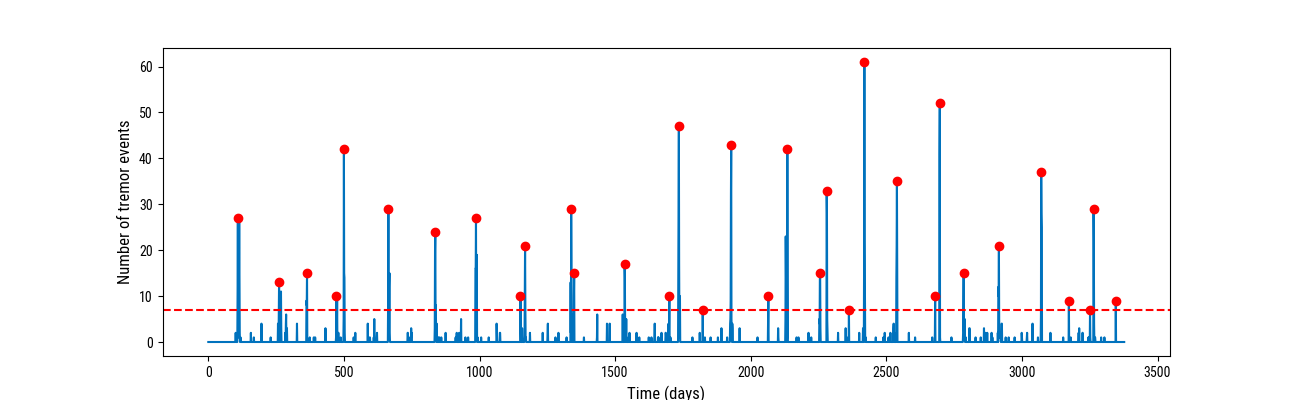

In [18]:
# For 1 count
count = counts[10]

threshold = np.percentile(counts, 99)
print(threshold)

from scipy.signal import find_peaks
peaks, _ = find_peaks(count, height=threshold, distance=10)

print('Average DT = {:.1f} days'.format(np.mean(np.diff(count_time[peaks]))))
print('Std DT = {:.1f} days'.format(np.std(np.diff(count_time[peaks]))))
print('Coeff of variation: {:.2f}'.format(np.std(np.diff(count_time[peaks])) / np.mean(np.diff(count_time[peaks]))))

fig, ax = plt.subplots(figsize=(13, 4))
ax.plot(count_time[:-1], count)
ax.plot(count_time[peaks], count[peaks], 'o', color='r')
ax.axhline(threshold, color='r', ls='--')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Number of tremor events')
plt.show()

In [19]:
# For all counts
from scipy.signal import find_peaks
dTs = []

threshold = np.percentile(counts, 99)
print('Peak = more than {:.0f} events in a day'.format(threshold))

for count in counts:
    if count.sum() == 0:
        dTs.append([])
    else:
        peaks, _ = find_peaks(count, height=threshold, distance=10)
        dT = np.diff(count_time[peaks])
        dTs.append(dT)

# mean where there are values, 0 if not
mean_dT = np.array([np.mean(dT) if len(dT) else 0 for dT in dTs])
median_dT = np.array([np.median(dT) if len(dT) else 0 for dT in dTs])
dT_80 = np.array([np.percentile(dT, 80) if len(dT) else 0 for dT in dTs])
std_dT = np.array([np.std(dT) if len(dT) else 0 for dT in dTs])
import scipy.stats
kurt_dT = np.array([scipy.stats.kurtosis(dT) if len(dT) else 0 for dT in dTs])

Peak = more than 7 events in a day


/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_52015/1798986857.py:4: RuntimeWarning: invalid value encountered in divide
  ax.plot(x_bin_edges[:-1], mean_dT/std_dT, color='C1', label='periodicity (mean/std)(dT)')
/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_52015/1798986857.py:15: RuntimeWarning: invalid value encountered in divide
  ax.plot(n_close_eq[chosen_dist], mean_dT/std_dT, 'o', label='periodicity (mean/std)(dT)', ms=8, mec='k', mfc=to_rgba('C1', .5))


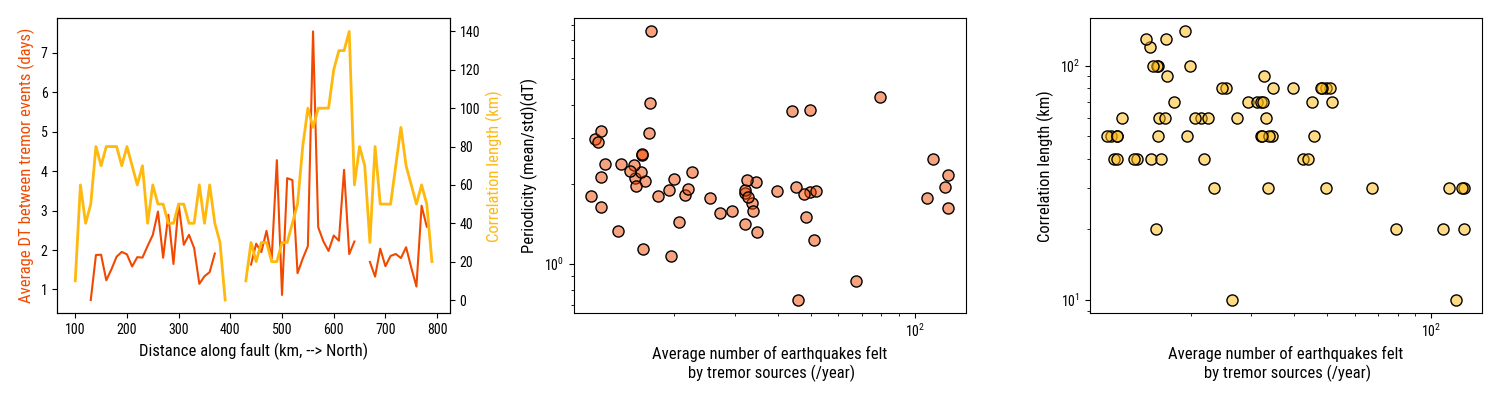

In [20]:
# Results
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
ax = axes[0]
ax.plot(x_bin_edges[:-1], mean_dT/std_dT, color='C1', label='periodicity (mean/std)(dT)')
ax.set_xlabel('Distance along fault (km, --> North)')
ax.set_ylabel('Average DT between tremor events (days)', c='C1')

ax_ = ax.twinx()
ax_.set_ylabel('Correlation length (km)', color='C2')
ax_.plot(x_bin_edges[:-1], corr_length, 'C2-', lw=2, label='Correlation length')

ax = axes[1]
ax.set_xlabel('Average number of earthquakes felt\n by tremor sources (/year)')
ax.set_ylabel('Periodicity (mean/std)(dT)')
ax.plot(n_close_eq[chosen_dist], mean_dT/std_dT, 'o', label='periodicity (mean/std)(dT)', ms=8, mec='k', mfc=to_rgba('C1', .5))

ax.set_xscale('log')
ax.set_yscale('log') 

ax = axes[2]
ax.plot(n_close_eq[chosen_dist], corr_length, 'o', label='Correlation length', ms=8, mec='k', mfc=to_rgba('C2', .5))
ax.set_ylabel('Correlation length (km)')
ax.set_xlabel('Average number of earthquakes felt\n by tremor sources (/year)')

ax.set_xscale('log')
ax.set_yscale('log')

plt.tight_layout()
plt.show()

# 4. <a id='toc4_'></a>Figures for paper [&#128285;](#toc0_)

## 4.1. <a id='toc4_1_'></a>Supplementary figure [&#128285;](#toc0_)

/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_52015/2135346290.py:105: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([], [], s=5, c=to_rgba('C1', .5), label='Tremor')
/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_52015/2135346290.py:106: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([], [], s=5, c=to_rgba('k', .5), label='Earthquakes')


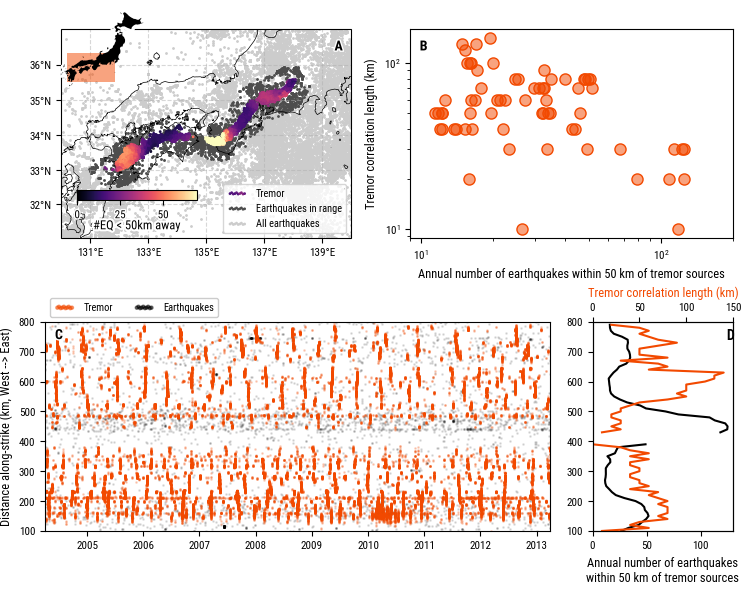

In [21]:
# Plot
import matplotlib.patheffects as fx

with plt.style.context('grl'):
    fig = plt.figure(figsize=np.array([19, 15])/2.54)
    gs = fig.add_gridspec(2, 4, width_ratios=[1, 1, 1, 1], height_ratios=[1, 1])

    plt.subplots_adjust(left=0.06, right=0.98, top=.95, bottom=0.1, wspace=0.3, hspace=0.4)

    # Map
    crs = ccrs.Mercator(central_longitude=trm.lon.mean())
    lon_min = eq.lon.min()
    lon_max = eq.lon.max()
    lat_min = eq.lat.min()
    lat_max = eq.lat.max()

    ax = fig.add_subplot(gs[0, :2], projection=crs)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.coastlines(lw=.5)

    sc = ax.scatter(trm.lon, trm.lat, c=trm.n_eq_50km, s=1, cmap='magma', transform=ccrs.PlateCarree(), vmin=0, vmax=np.percentile(trm.n_eq_50km, 95), zorder=2, label='Tremor', rasterized=True)
    ax.scatter(eq.lon[eq.in50km], eq.lat[eq.in50km], c='.3', s=1, transform=ccrs.PlateCarree(), zorder=1, label='Earthquakes in range', rasterized=True)
    ax.scatter(eq.lon, eq.lat, c='.8', s=1, transform=ccrs.PlateCarree(), zorder=0, label='All earthquakes', rasterized=True)

    ax.legend(loc='lower right', bbox_to_anchor=(1, 0), fontsize='small', framealpha=.8, scatterpoints=10, markerscale=1)

    # Colorbar
    x_min_ax = 0.1; y_min_ax = 0.18
    w_ax = 0.37; h_ax = 0.05
    x_max_ax = x_min_ax + w_ax; y_max_ax = y_min_ax + h_ax

    x_min_fig, y_min_fig = fig.transFigure.inverted().transform(ax.transAxes.transform([x_min_ax, y_min_ax]))
    x_max_fig, y_max_fig = fig.transFigure.inverted().transform(ax.transAxes.transform([x_max_ax, y_max_ax]))
    h_fig = y_max_fig - y_min_fig
    w_fig = x_max_fig - x_min_fig

    cb_ax= fig.add_axes([x_min_fig, y_min_fig, w_fig, h_fig])
    cbar = plt.colorbar(sc, cax=cb_ax, orientation='horizontal', label="#EQ < {:d}km away".format(chosen_dist))

    for label in cb_ax.get_xticklabels():
        label.set(path_effects=[fx.withStroke(linewidth=2, foreground='w')])
    cb_ax.xaxis.get_label().set(path_effects=[fx.withStroke(linewidth=3, foreground='w')])
    cb_ax.xaxis.get_label().set_va('center')

    # grid and labels, only bottom and left, not top and right
    ax.set_xticks(np.arange(np.ceil(lon_min), lon_max+1, 2), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(np.ceil(lat_min), lat_max, 1), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.grid('on', linestyle='--', alpha=0.5)

    ax.text(0.97, 0.95, 'A', fontsize=10, fontweight='bold', transform=ax.transAxes, ha='right', va='top', path_effects=[fx.withStroke(linewidth=2, foreground='w')])


    # Inset
    # get Japan country shape
    import shapely.geometry as sgeom
    import cartopy.io.shapereader as shpreader

    shpfilename = shpreader.natural_earth(resolution='50m',
                                        category='cultural',
                                        name='admin_0_countries')
    reader = shpreader.Reader(shpfilename)
    countries = reader.records()

    japan = None
    for country in countries:
        if country.attributes['NAME'] == 'Japan':
            japan = country.geometry

    ax = plt.axes([.07, .85, .13, .13], projection=ccrs.PlateCarree())
    ax.axis('off')
    ax.set_extent([128, 146, 29.8, 45.7], crs=ccrs.PlateCarree())
    ax.add_geometries([japan], ccrs.PlateCarree(), facecolor='k', edgecolor='w', lw=4, zorder=0)    
    ax.add_geometries([japan], ccrs.PlateCarree(), facecolor='k', edgecolor='none', lw=1, zorder=2)

    # show patch of main map
    rect = plt.Rectangle((lon_min, lat_min), lon_max-lon_min, lat_max-lat_min, transform=ccrs.PlateCarree(), edgecolor='none', facecolor=to_rgba('C1', .5), zorder=1)
    ax.add_patch(rect)

    # Dot cloud
    ax = fig.add_subplot(gs[0, 2:])
    ax.set_xlabel('Annual number of earthquakes within 50 km of tremor sources')
    ax.set_ylabel('Tremor correlation length (km)')

    ax.plot(n_close_eq[chosen_dist], corr_length, 'o', ms=8, mec='C1', mfc=to_rgba('C1', .5))

    ax.set_xlim(9, 200)
    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.text(0.03, 0.95, 'B', fontsize=10, fontweight='bold', transform=ax.transAxes, ha='left', va='top', path_effects=[fx.withStroke(linewidth=2, foreground='w')])


    # Time-strike activity
    ax = fig.add_subplot(gs[1, :3])
    ax.set_ylabel('Distance along-strike (km, West --> East)')

    ax.plot(trm.date, trm.xf, 'o', ms=1, color=to_rgba('C1', .2), rasterized=True)
    ax.plot(eq.date[eq.in50km], eq.xf[eq.in50km], 'o', ms=1., color=to_rgba('k', .1), zorder=0, rasterized=True)

    ax.set_xlim(trm.date.min(), trm.date.max())
    ax.set_ylim(100, 800)

    ax.scatter([], [], s=5, c=to_rgba('C1', .5), label='Tremor')
    ax.scatter([], [], s=5, c=to_rgba('k', .5), label='Earthquakes')
    ax.legend(loc='lower left', bbox_to_anchor=(0, 1.), framealpha=1, fontsize='small', scatterpoints=10, markerscale=1, ncols=2)

    ax.text(0.02, 0.97, 'C', fontsize=10, fontweight='bold', transform=ax.transAxes, ha='left', va='top', path_effects=[fx.withStroke(linewidth=2, foreground='w')])

    # Histogram
    ax = fig.add_subplot(gs[1, 3], sharey=ax)
    ax.set_xlabel('Annual number of earthquakes\nwithin 50 km of tremor sources')
    ax.set_xlim(0, 130)

    ax.plot(n_close_eq[chosen_dist], x_bin_edges[:-1], c='k')

    ax_cc = ax.twiny()
    ax_cc.set_xlim(0, 150)
    ax_cc.plot(corr_length, x_bin_edges[:-1], 'C1')
    ax_cc.set_xlabel('Tremor correlation length (km)', color='C1')

    ax.text(0.95, 0.97, 'D', fontsize=10, fontweight='bold', transform=ax.transAxes, ha='left', va='top')
    
    plt.savefig('figures/nankai_supp.png', dpi=300)
    plt.savefig('figures/nankai_supp.pdf', dpi=300)
    plt.show()